In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, HTML

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Ensure full representation of the 'Representation' column
pd.set_option('display.max_colwidth', None)

# Function to display DataFrame as a scrollable element
def display_scrollable(df, max_height=400):
    display(HTML(df.to_html(notebook=True, max_rows=None, max_cols=None, border=0, justify='center', escape=False)))
    display(HTML(f"<style>div.dataframe {{ max-height: {max_height}px; overflow-y: scroll; }}</style>"))

print("📊 Visualization and Analysis Notebook")
print("=" * 50)

📊 Visualization and Analysis Notebook


In [31]:
# === LOAD PROCESSED DATA ===
print("📂 Loading processed datasets with topics...")

# Load main datasets with topics
AT = pd.read_pickle(r"data folder\AT\AT_with_topics.pkl")
HR = pd.read_pickle(r"data folder\HR\HR_with_topics.pkl")
GB = pd.read_pickle(r"data folder\GB\GB_with_topics.pkl")

# Load topic information dataframes
gb_topics = pd.read_pickle(r"data folder\GB\GB_topic_info.pkl")
at_en_topics = pd.read_pickle(r"data folder\AT\AT_topic_info_english.pkl")
at_de_topics = pd.read_pickle(r"data folder\AT\AT_topic_info_german.pkl")
hr_en_topics = pd.read_pickle(r"data folder\HR\HR_topic_info_english.pkl")
hr_hr_topics = pd.read_pickle(r"data folder\HR\HR_topic_info_croatian.pkl")

topics_cols = ['Topic', 'Subtopic_Name','Category', 'Count', 'Representation']
# only select relevant columns
gb_topics = gb_topics[topics_cols]
at_en_topics = at_en_topics[topics_cols]
at_de_topics = at_de_topics[topics_cols]
hr_en_topics = hr_en_topics[topics_cols]
hr_hr_topics = hr_hr_topics[topics_cols]    

print("✅ Data loaded successfully:")
print(f"   • AT: {AT.shape}")
print(f"   • HR: {HR.shape}")
print(f"   • GB: {GB.shape}")
print(f"   • Topic info files: 5 dataframes")

📂 Loading processed datasets with topics...
✅ Data loaded successfully:
   • AT: (231759, 44)
   • HR: (504338, 44)
   • GB: (670912, 35)
   • Topic info files: 5 dataframes
✅ Data loaded successfully:
   • AT: (231759, 44)
   • HR: (504338, 44)
   • GB: (670912, 35)
   • Topic info files: 5 dataframes


In [42]:
print(AT[AT['Topic'] == 'Other'].shape[0] / len(AT))
print(AT[AT['Speaker_role'] == 'Chairperson'].shape[0] / len(AT))

print(GB[GB['Topic'] == 'Other'].shape[0] / len(GB))
print(GB[GB['Speaker_role'] == 'Chairperson'].shape[0] / len(GB))

print(HR[HR['Topic'] == 'Other'].shape[0] / len(HR))
print(HR[HR['Speaker_role'] == 'Chairperson'].shape[0] / len(HR))

0.5195310645972756
0.5395346027554485
0.14347634265000478
0.024362360488409805
0.5257605018856402
0.4889280601501374


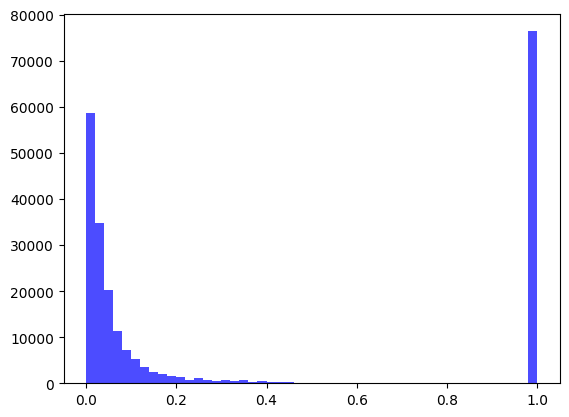

Rows with low confidence(<0.5): 154948 66.86%
Rows with max confidence: 76370 32.95%
Rows with max confidence: 76370 32.95%


In [32]:
plt.hist(AT['Segment_Topic_Confidence_AT_english'], bins=50, alpha=0.7, color='blue')
plt.show()

# how many rows have confidence below 0.5
low_confidence_count = AT[AT['Segment_Topic_Confidence_AT_english'] < 0.5].shape[0]
print(f"Rows with low confidence(<0.5): {low_confidence_count} {low_confidence_count / AT.shape[0] * 100:.2f}%")

high_confidence_count = AT[AT['Segment_Topic_Confidence_AT_english'] == 1].shape[0]
print(f"Rows with max confidence: {high_confidence_count} {high_confidence_count / AT.shape[0] * 100:.2f}%")

📊 Category Distribution Analysis - Segment Counts by Policy Category

📋 GB Analysis:


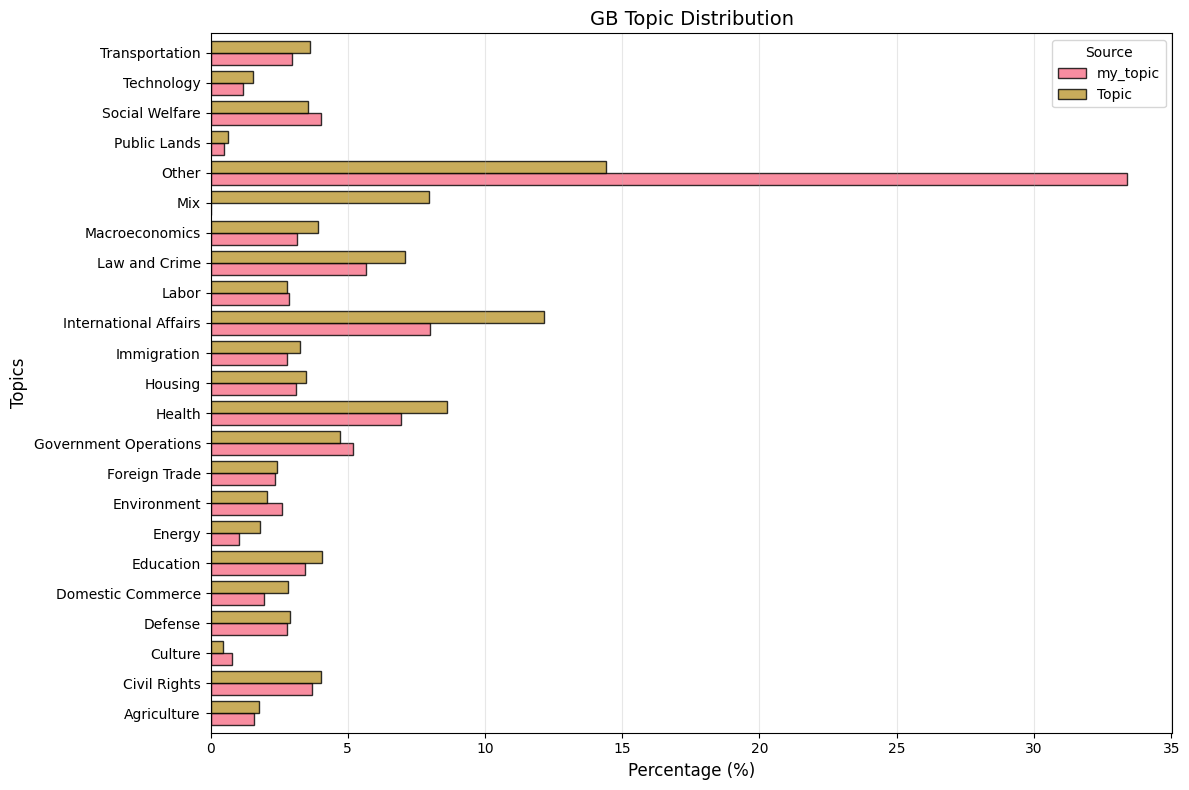


📋 HR Analysis:


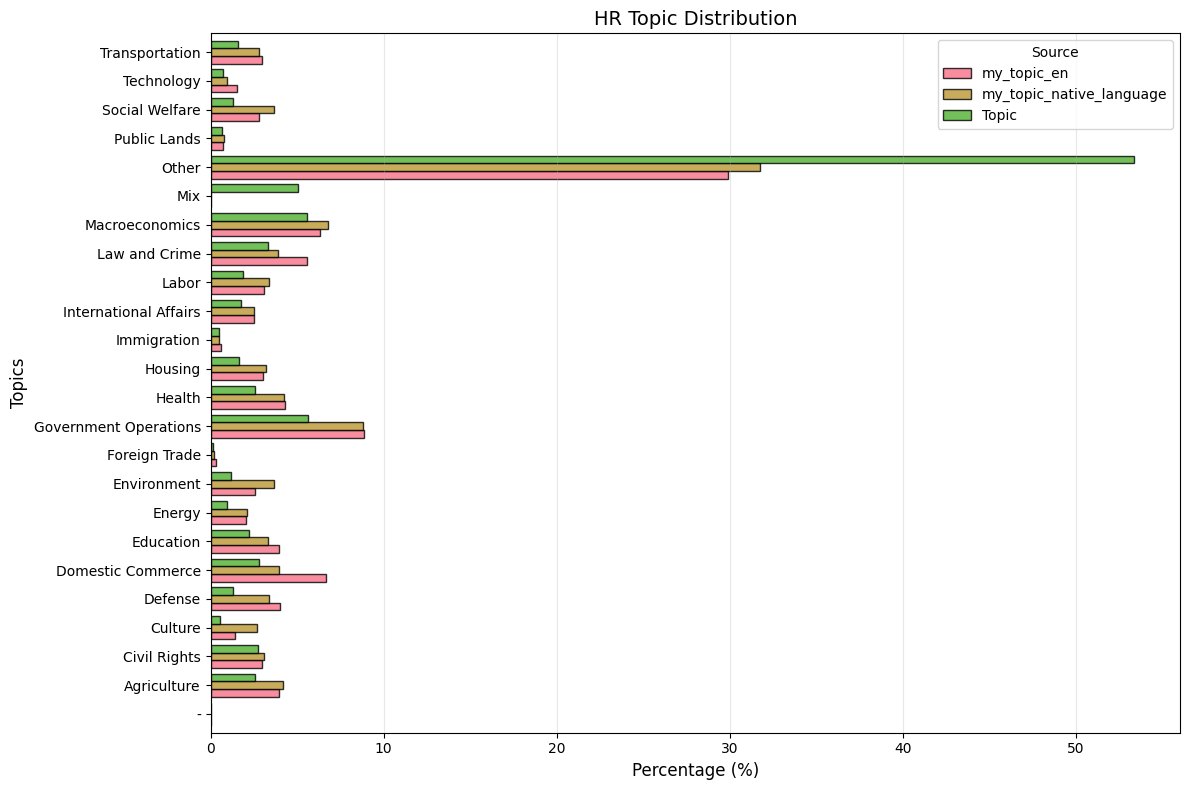


📋 AT Analysis:


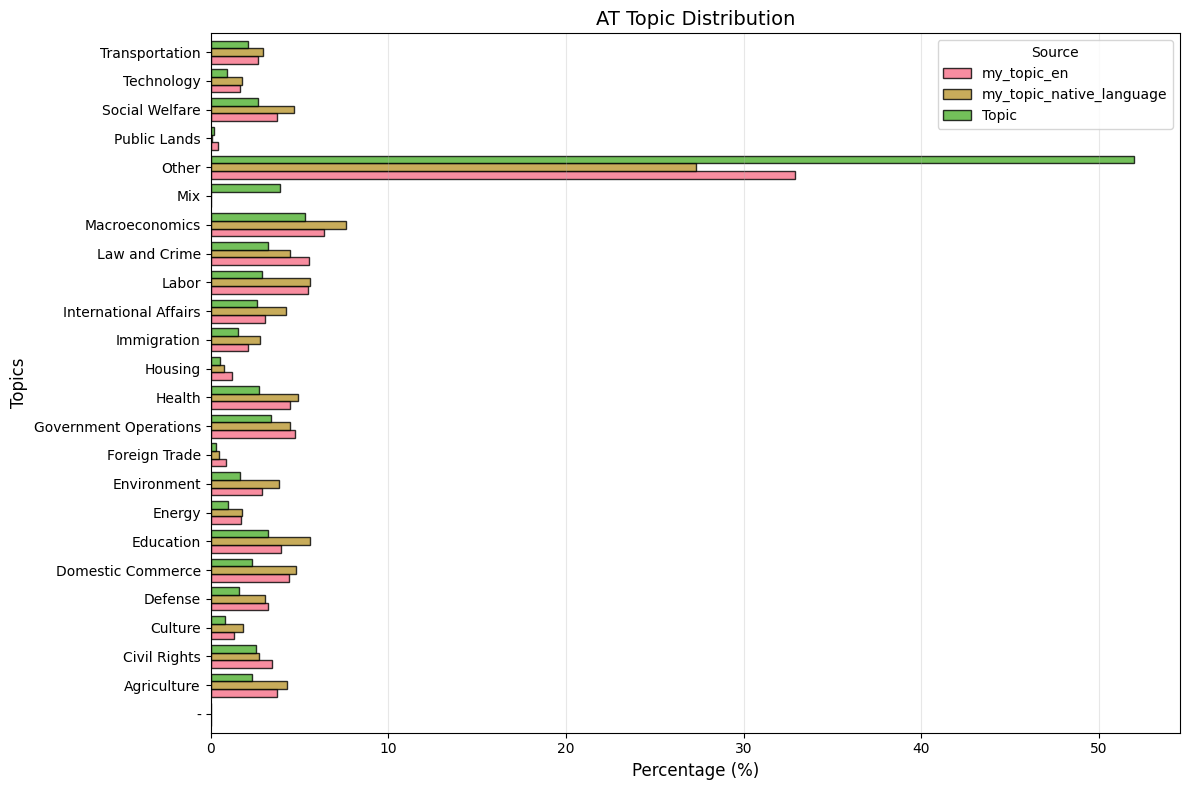

In [33]:
# === CATEGORY DISTRIBUTION ANALYSIS ===
print("📊 Category Distribution Analysis - Segment Counts by Policy Category")
print("=" * 80)

datasets_to_analyze = [
    ('GB', GB, 'my_topic', 'Topic'),
    ('HR', HR, 'my_topic_en', 'my_topic_native_language', 'Topic'),
    ('AT', AT, 'my_topic_en', 'my_topic_native_language', 'Topic')
]

for dataset_name, df, *topic_columns in datasets_to_analyze:
    if df is not None and all(col in df.columns for col in topic_columns):
        print(f"\n📋 {dataset_name} Analysis:")
        
        # Calculate percentages for each topic column
        topic_percentages = {}
        total_segments = len(df)
        for col in topic_columns:
            topic_percentages[col] = df[col].value_counts(normalize=True) * 100
        
        # Combine data into a single DataFrame for plotting
        combined_data = pd.DataFrame(topic_percentages).fillna(0)
        combined_data = combined_data.sort_index()
        
        # Plot the data
        ax = combined_data.plot(
            kind='barh',  # Horizontal bar plot
            figsize=(12, 8), 
            width=0.8, 
            alpha=0.8,
            edgecolor='black'
        )
        
        ax.set_title(f'{dataset_name} Topic Distribution', fontsize=14)
        ax.set_ylabel('Topics', fontsize=12)
        ax.set_xlabel('Percentage (%)', fontsize=12)
        ax.legend(title='Source', fontsize=10)
        ax.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"❌ {dataset_name}: Data not available or missing required columns")


🎯 SAMPLED POLICY TOPICS ANALYSIS

🎯 Policy Topics Analysis for GB Policy Topics (Sampling Approach)
📊 Chairperson Filtering:
   • Original segments: 670,912
   • After removing chairperson: 654,567 (16,345 removed)

📊 Word Count Distribution for Text:
   • Min: 1 words
   • Max: 26505 words
   • Mean: 188.9 words
   • Median: 81.0 words

📊 Word Count Filtering:
   • After chairperson filter: 654,567
   • After short word filter: 86,847 (567,720 removed)
   • Percentage kept: 13.3%
   • After removing Mix/Other from both: 56,295 (30,552 Mix/Other removed)

📊 Sampling 20 speeches per CAP label (policy categories only):
   • Total sampled speeches: 420

📈 Sampled Dataset Metrics (Policy Only):
   • Macro F1 Score: 0.667
   • Accuracy: 0.669 (281/420)


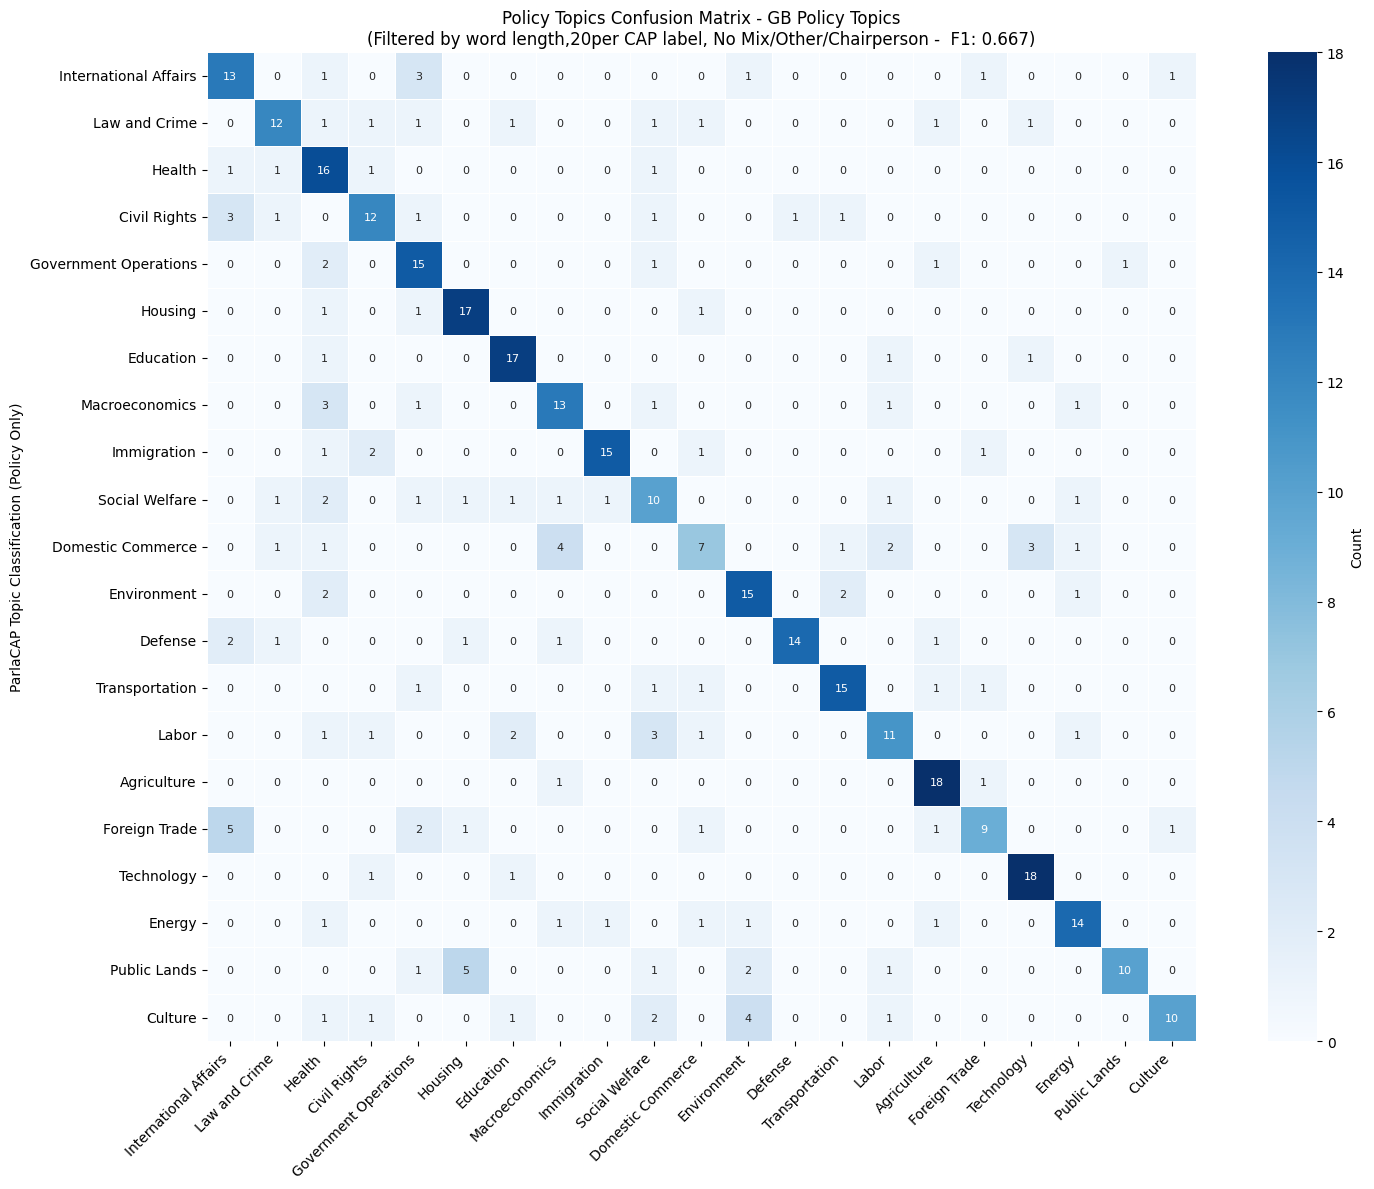

✅ Policy-only confusion matrix: 21 categories, 420 total speeches

🎯 Policy Topics Analysis for HR-EN Policy Topics (Sampling Approach)
📊 Chairperson Filtering:
   • Original segments: 504,334
   • After removing chairperson: 257,750 (246,584 removed)

📊 Word Count Distribution for Text:
   • Min: 1 words
   • Max: 9803 words
   • Mean: 365.2 words
   • Median: 184.0 words

📊 Word Count Filtering:
   • After chairperson filter: 257,750
   • After short word filter: 60,367 (197,383 removed)
   • Percentage kept: 23.4%
   • After removing Mix/Other from both: 40,735 (19,632 Mix/Other removed)

📊 Sampling 20 speeches per CAP label (policy categories only):
   • Total sampled speeches: 420

📈 Sampled Dataset Metrics (Policy Only):
   • Macro F1 Score: 0.640
   • Accuracy: 0.643 (270/420)


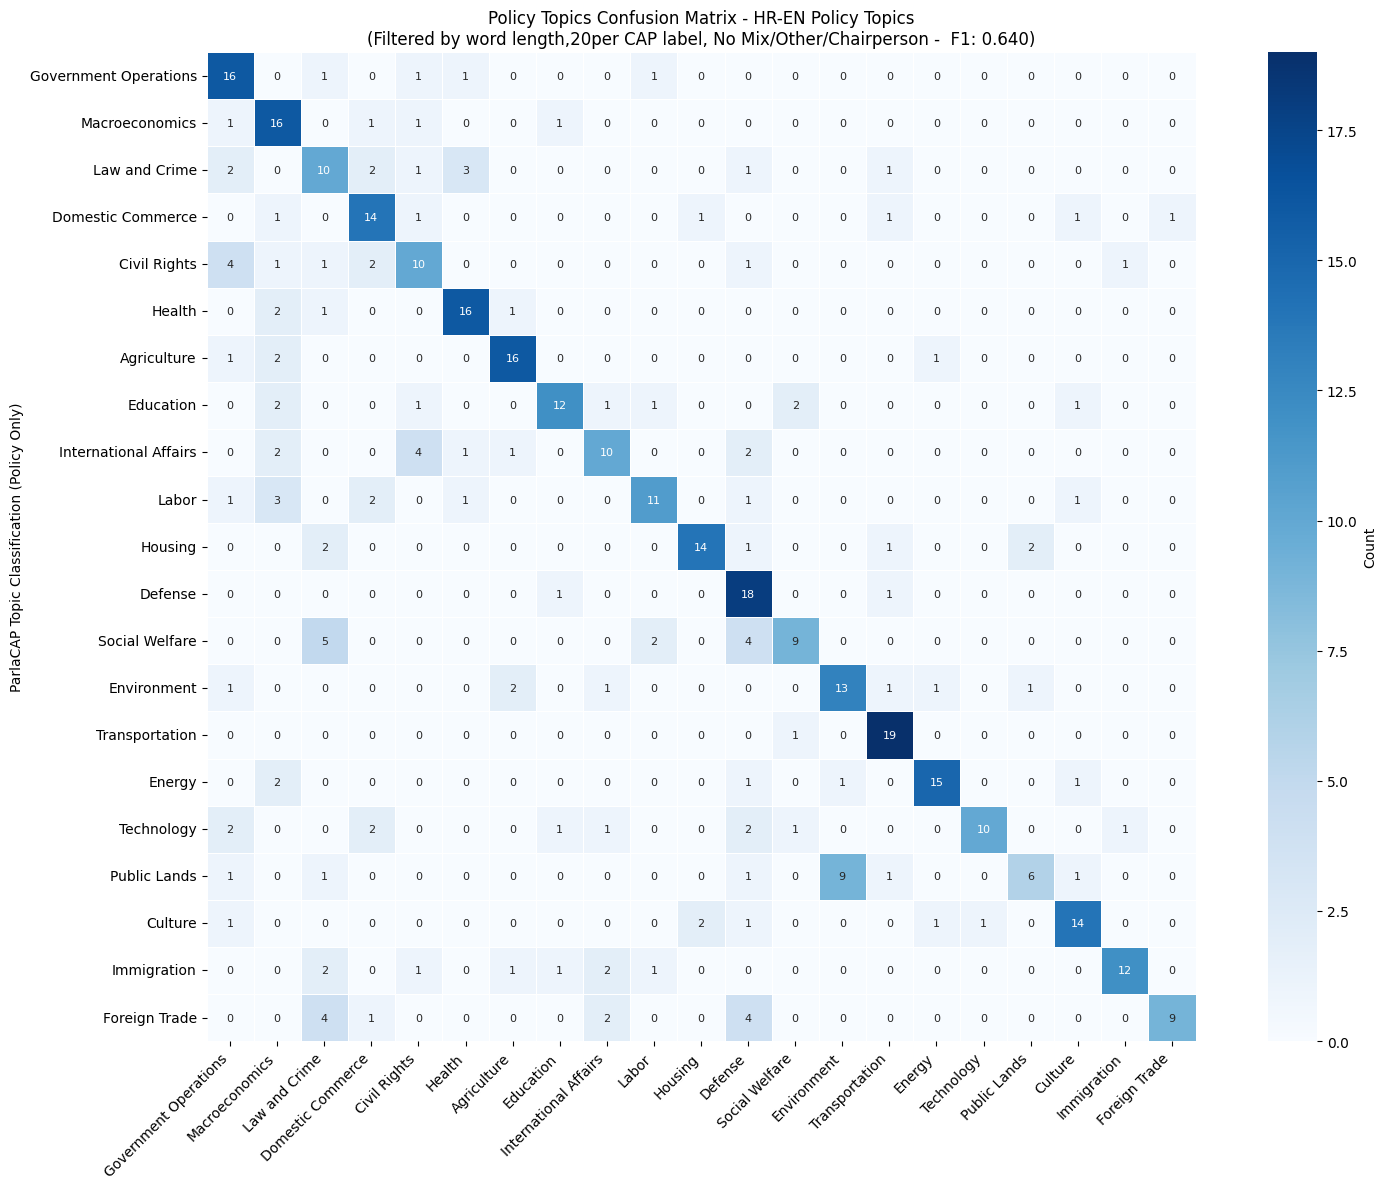

✅ Policy-only confusion matrix: 21 categories, 420 total speeches

🎯 Policy Topics Analysis for HR-Croatian Policy Topics (Sampling Approach)
📊 Chairperson Filtering:
   • Original segments: 504,334
   • After removing chairperson: 257,750 (246,584 removed)

📊 Word Count Distribution for Text:
   • Min: 1 words
   • Max: 9803 words
   • Mean: 365.2 words
   • Median: 184.0 words

📊 Word Count Filtering:
   • After chairperson filter: 257,750
   • After short word filter: 60,367 (197,383 removed)
   • Percentage kept: 23.4%
   • After removing Mix/Other from both: 39,111 (21,256 Mix/Other removed)

📊 Sampling 20 speeches per CAP label (policy categories only):
   • Total sampled speeches: 420

📈 Sampled Dataset Metrics (Policy Only):
   • Macro F1 Score: 0.601
   • Accuracy: 0.612 (257/420)


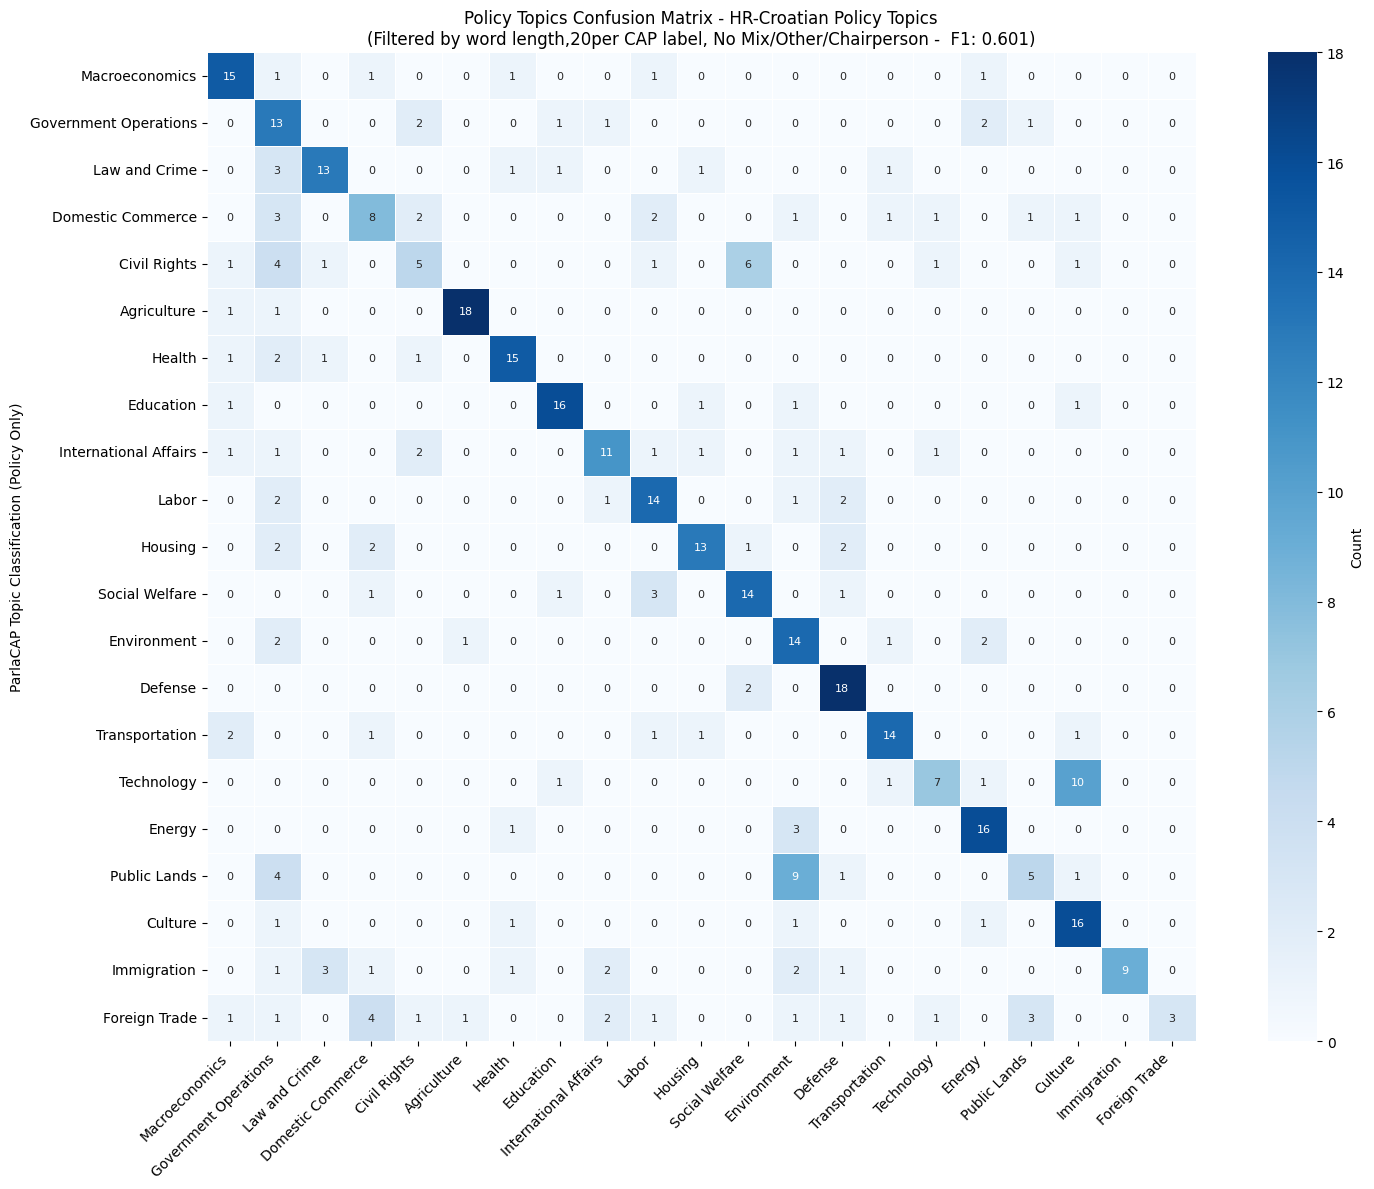

✅ Policy-only confusion matrix: 21 categories, 420 total speeches

🎯 Policy Topics Analysis for AT-EN Policy Topics (Sampling Approach)
📊 Chairperson Filtering:
   • Original segments: 231,758
   • After removing chairperson: 106,716 (125,042 removed)

📊 Word Count Distribution for Text:
   • Min: 1 words
   • Max: 10666 words
   • Mean: 585.7 words
   • Median: 493.0 words

📊 Word Count Filtering:
   • After chairperson filter: 106,716
   • After short word filter: 63,337 (43,379 removed)
   • Percentage kept: 59.4%
   • After removing Mix/Other from both: 40,889 (22,448 Mix/Other removed)

📊 Sampling 20 speeches per CAP label (policy categories only):
   • Total sampled speeches: 420

📈 Sampled Dataset Metrics (Policy Only):
   • Macro F1 Score: 0.652
   • Accuracy: 0.655 (275/420)


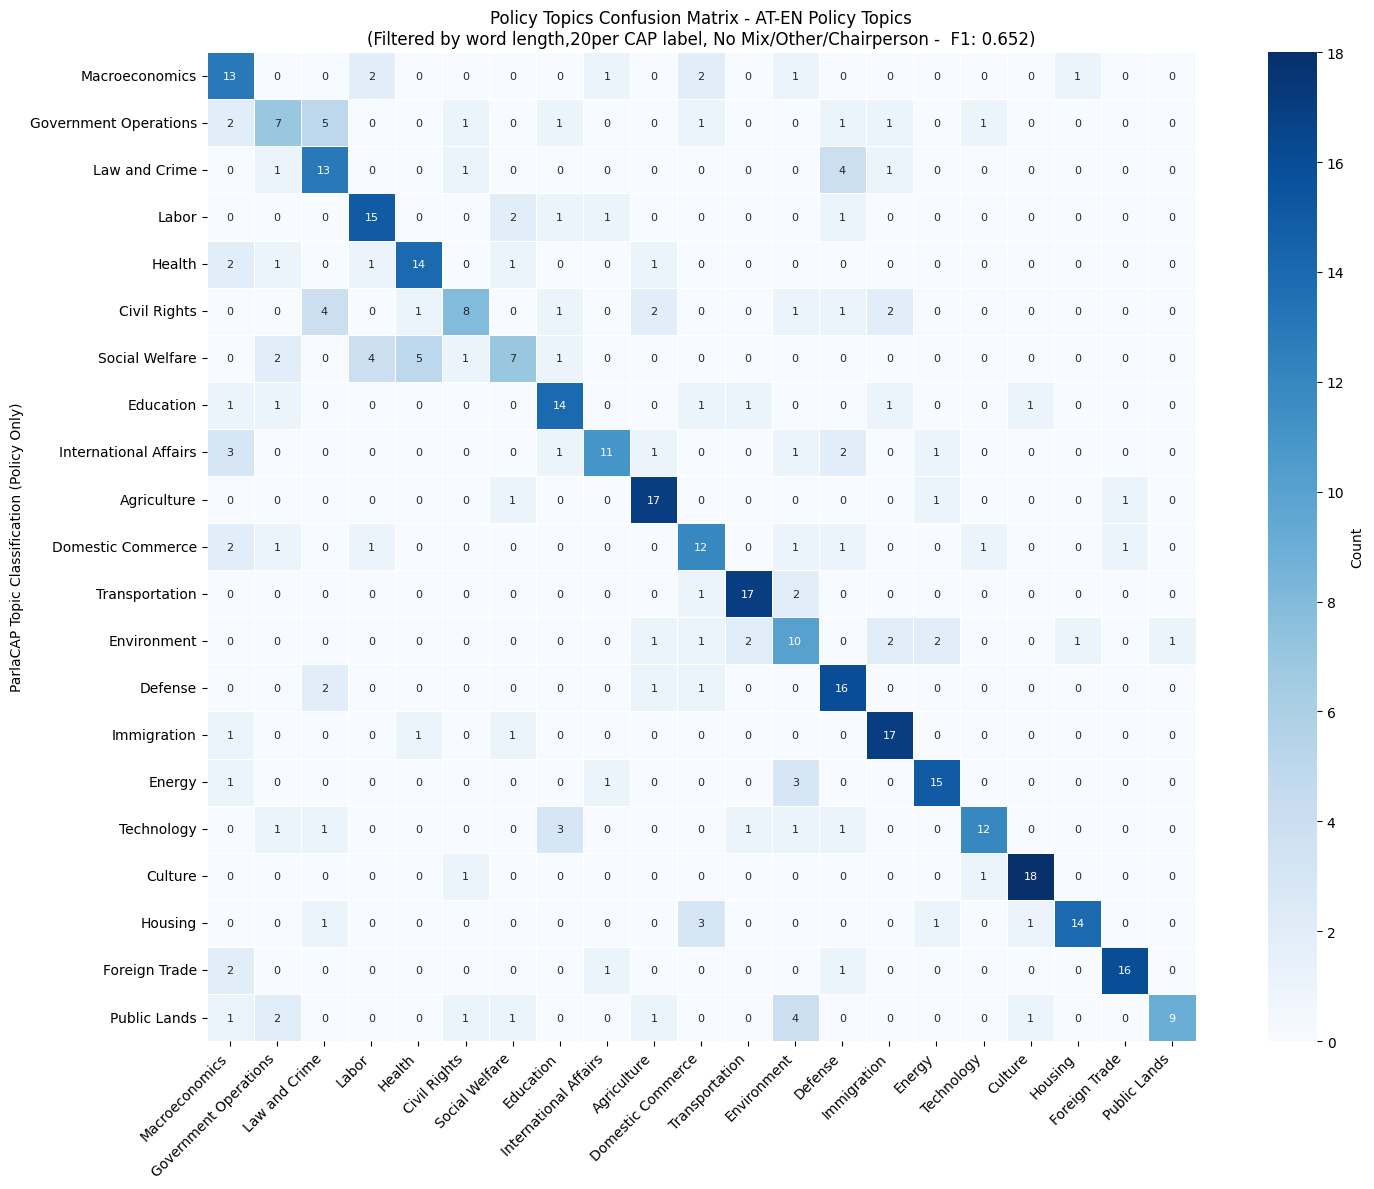

✅ Policy-only confusion matrix: 21 categories, 420 total speeches

🎯 Policy Topics Analysis for AT-German Policy Topics (Sampling Approach)
📊 Chairperson Filtering:
   • Original segments: 231,758
   • After removing chairperson: 106,716 (125,042 removed)

📊 Word Count Distribution for Text:
   • Min: 1 words
   • Max: 10666 words
   • Mean: 585.7 words
   • Median: 493.0 words

📊 Word Count Filtering:
   • After chairperson filter: 106,716
   • After short word filter: 63,337 (43,379 removed)
   • Percentage kept: 59.4%
   • After removing Mix/Other from both: 44,337 (19,000 Mix/Other removed)

📊 Sampling 20 speeches per CAP label (policy categories only):
   • Total sampled speeches: 420

📈 Sampled Dataset Metrics (Policy Only):
   • Macro F1 Score: 0.536
   • Accuracy: 0.540 (227/420)


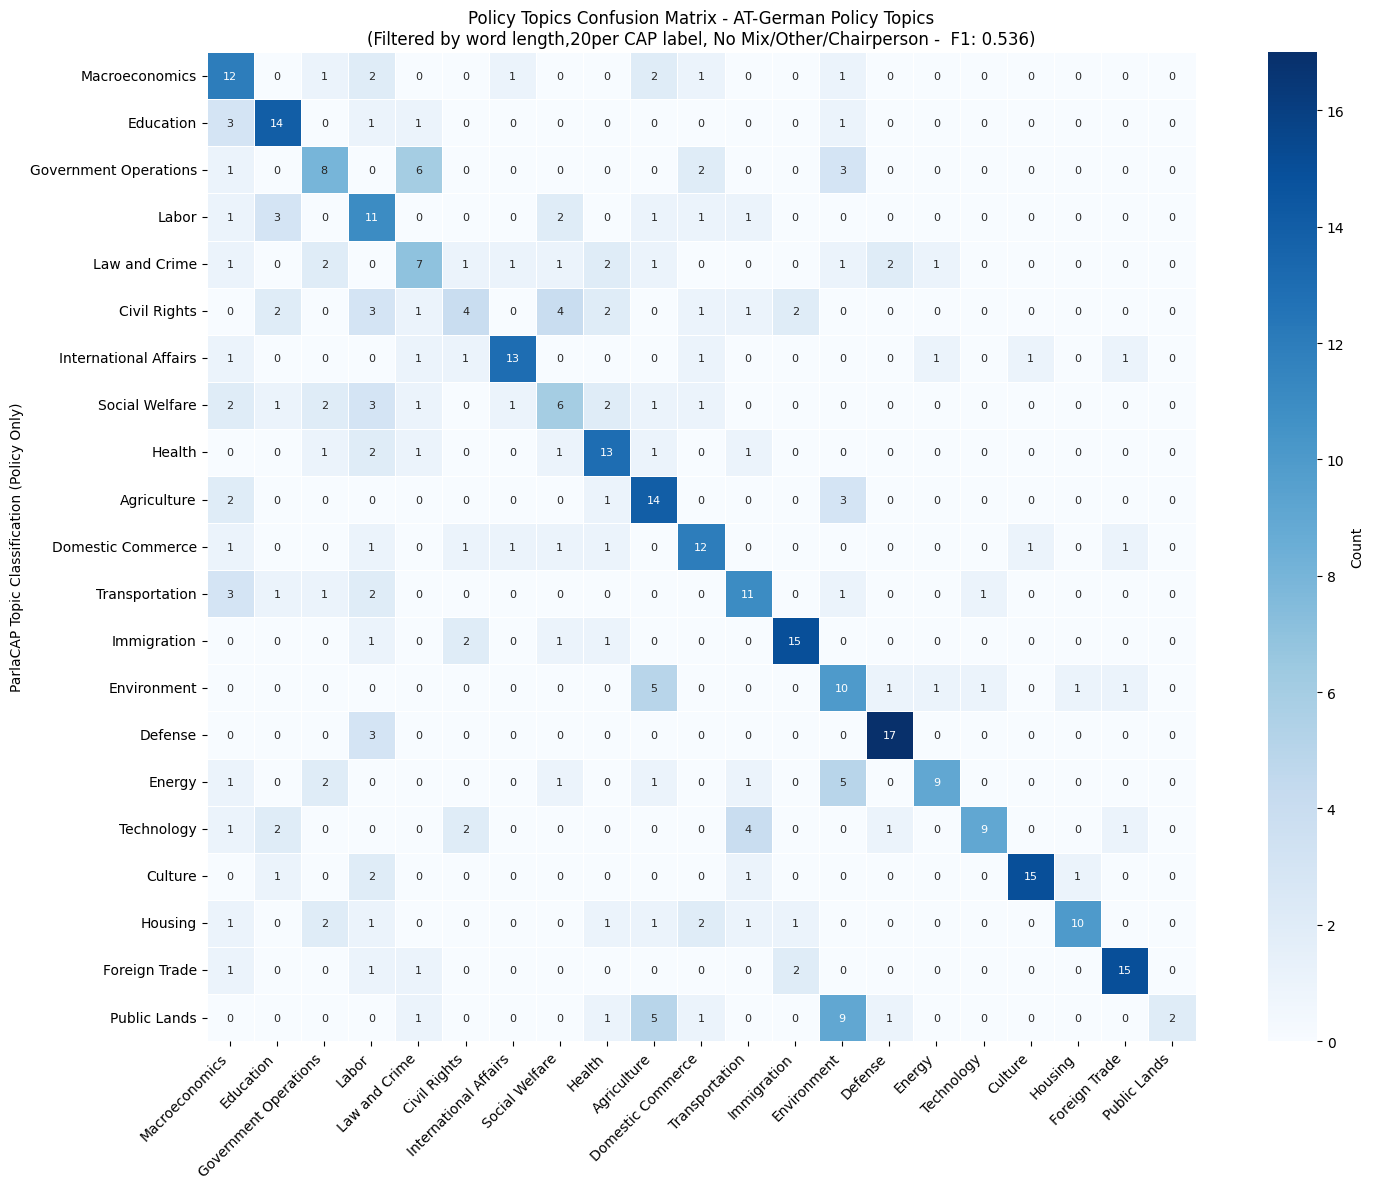

✅ Policy-only confusion matrix: 21 categories, 420 total speeches

📊 SAMPLED POLICY TOPICS SUMMARY
GB (Sampled):
   • Macro F1 Score: 0.667
   • Accuracy: 0.669 (281/420)
   • Categories: 21
HR_EN (Sampled):
   • Macro F1 Score: 0.640
   • Accuracy: 0.643 (270/420)
   • Categories: 21
HR_Native (Sampled):
   • Macro F1 Score: 0.601
   • Accuracy: 0.612 (257/420)
   • Categories: 21
AT_EN (Sampled):
   • Macro F1 Score: 0.652
   • Accuracy: 0.655 (275/420)
   • Categories: 21
AT_Native (Sampled):
   • Macro F1 Score: 0.536
   • Accuracy: 0.540 (227/420)
   • Categories: 21

💡 This analysis follows the paper's methodology: 200-1000 words, 20 samples per CAP label, policy categories only


In [48]:
# === POLICY-FOCUSED CONFUSION MATRIX (SAMPLING APPROACH) ===

def analyze_policy_topics_sampled(df, my_topic_col, parlacap_topic_column, dataset_name):
    """
    Create confusion matrix using sampling approach from the paper:
    1) Filter speeches by word count (56-306 words)
    2) Remove chairperson speeches, Mix labels, and Other labels
    3) Sample 20 speeches per CAP label (21 policy categories only)
    """
    print(f"\n🎯 Policy Topics Analysis for {dataset_name} (Sampling Approach)")
    print("=" * 60)
    
    # Remove the weird category "-"
    df = df[~df[parlacap_topic_column].isin(['-'])]
    
    # Clean data first
    # df = df.dropna(subset=[my_topic_col, parlacap_topic_column])
    
    # STEP 1: Filter out chairperson speeches (as done in the paper)
    chairperson_filtered_df = df[df['Speaker_role'] != 'Chairperson']
    print(f"📊 Chairperson Filtering:")
    print(f"   • Original segments: {len(df):,}")
    print(f"   • After removing chairperson: {len(chairperson_filtered_df):,} ({len(df) - len(chairperson_filtered_df):,} removed)")
    df = chairperson_filtered_df

    
    # STEP 2: Filter by word count
    text_column = 'Text'
    
    # Calculate word counts
    df = df.copy()
    df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
    
    # Show word count distribution
    print(f"\n📊 Word Count Distribution for {text_column}:")
    print(f"   • Min: {df['word_count'].min()} words")
    print(f"   • Max: {df['word_count'].max()} words")
    print(f"   • Mean: {df['word_count'].mean():.1f} words")
    print(f"   • Median: {df['word_count'].median():.1f} words")

    # Filter by word count
    word_filtered_df = df[(df['word_count'] >=400)]

    print(f"\n📊 Word Count Filtering:")
    print(f"   • After chairperson filter: {len(df):,}")
    print(f"   • After short word filter: {len(word_filtered_df):,} ({len(df) - len(word_filtered_df):,} removed)")
    print(f"   • Percentage kept: {(len(word_filtered_df) / len(df) * 100):.1f}%")
    
    
    # STEP 3: Remove Mix and Other labels from BOTH classifications
    no_mix_other_df = word_filtered_df[
        (~word_filtered_df[parlacap_topic_column].isin(['Mix', 'Other'])) & 
        (~word_filtered_df[my_topic_col].isin(['Mix', 'Other']))
    ]
    
    print(f"   • After removing Mix/Other from both: {len(no_mix_other_df):,} ({len(word_filtered_df) - len(no_mix_other_df):,} Mix/Other removed)")
    
    # STEP 4: Sample 20 speeches per CAP label (policy categories only)
    print(f"\n📊 Sampling 20 speeches per CAP label (policy categories only):")
    
    # Get available categories
    available_categories = no_mix_other_df[parlacap_topic_column].value_counts()
    #print(f"   • Available policy categories: {len(available_categories)}")
    
    sampled_dfs = []
    sampling_stats = {}
    
    for category in available_categories.index:
        category_df = no_mix_other_df[no_mix_other_df[parlacap_topic_column] == category]
        
        if len(category_df) >= 20:
            sampled_df = category_df.sample(n=20, random_state=42)
            sampled_dfs.append(sampled_df)
            sampling_stats[category] = {'available': len(category_df), 'sampled': 20}
        else:
            # Take all available if less than 20
            sampled_dfs.append(category_df)
            sampling_stats[category] = {'available': len(category_df), 'sampled': len(category_df)}
    
    sampled_df = pd.concat(sampled_dfs, ignore_index=True)
    
    print(f"   • Total sampled speeches: {len(sampled_df):,}")
    
    # Calculate metrics
    my_topics = sampled_df[my_topic_col]
    parlacap_topics = sampled_df[parlacap_topic_column]
    
    from sklearn.metrics import f1_score
    f1_sampled = f1_score(parlacap_topics, my_topics, average='weighted',zero_division=0)
    exact_matches_sampled = (my_topics == parlacap_topics).sum()
    accuracy_sampled = exact_matches_sampled / len(sampled_df)
    
    print(f"\n📈 Sampled Dataset Metrics (Policy Only):")
    print(f"   • Macro F1 Score: {f1_sampled:.3f}") 
    print(f"   • Accuracy: {accuracy_sampled:.3f} ({exact_matches_sampled:,}/{len(sampled_df):,})")
    
    # Create confusion matrix
    plt.figure(figsize=(16, 12))
    
    # Get categories sorted by frequency in sampled data (no Other to put first)
    sampled_counts = parlacap_topics.value_counts()
    categories = sampled_counts.index.tolist()
    
    # Create confusion matrix with raw values
    conf_matrix = confusion_matrix(
        parlacap_topics, 
        my_topics,
        labels=categories
    )
    
    # Use raw values instead of percentages (since max is 20)
    conf_matrix_display = conf_matrix
    
    # Create the heatmap with raw values
    sns.heatmap(conf_matrix_display, 
               xticklabels=categories,
               yticklabels=categories,
               annot=True, 
               fmt='d',  # Integer format for raw values
               cmap='Blues',
               cbar_kws={'label': 'Count'},
               square=True,
               annot_kws={'size': 8},
               linewidths=0.5,
               linecolor='white')

    plt.title(f'Policy Topics Confusion Matrix - {dataset_name}\n(Filtered by word length,20per CAP label, No Mix/Other/Chairperson -  F1: {f1_sampled:.3f})')
    plt.ylabel('ParlaCAP Topic Classification (Policy Only)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Policy-only confusion matrix: {len(categories)} categories, {len(sampled_df)} total speeches")
    
    return {
        'f1_score_sampled': f1_sampled,
        'accuracy_sampled': accuracy_sampled,
        'exact_matches_sampled': exact_matches_sampled,
        'total_sampled_speeches': len(sampled_df),
        'categories_count': len(categories),
        'sampling_stats': sampling_stats
    }

# Run sampled analysis for all datasets
print("\n🎯 SAMPLED POLICY TOPICS ANALYSIS")
print("=" * 80)

sampled_results = {}

# Analyze GB policy topics
if 'my_topic' in GB.columns and 'Topic' in GB.columns:
    sampled_results['GB'] = analyze_policy_topics_sampled(GB, 'my_topic', 'Topic', 'GB Policy Topics')

# Analyze HR policy topics (English)
if 'my_topic_en' in HR.columns and 'Topic' in HR.columns:
    sampled_results['HR_EN'] = analyze_policy_topics_sampled(HR, 'my_topic_en', 'Topic', 'HR-EN Policy Topics')

# Analyze HR policy topics (Croatian - Native Language)
if 'my_topic_native_language' in HR.columns and 'Topic' in HR.columns:
    sampled_results['HR_Native'] = analyze_policy_topics_sampled(HR, 'my_topic_native_language', 'Topic', 'HR-Croatian Policy Topics')

# Analyze AT policy topics (English)
if 'my_topic_en' in AT.columns and 'Topic' in AT.columns:
    sampled_results['AT_EN'] = analyze_policy_topics_sampled(AT, 'my_topic_en', 'Topic', 'AT-EN Policy Topics')

# Analyze AT policy topics (German - Native Language)
if 'my_topic_native_language' in AT.columns and 'Topic' in AT.columns:
    sampled_results['AT_Native'] = analyze_policy_topics_sampled(AT, 'my_topic_native_language', 'Topic', 'AT-German Policy Topics')

# Sampled topics summary
print(f"\n📊 SAMPLED POLICY TOPICS SUMMARY")
print("=" * 50)
for dataset, results in sampled_results.items():
    if results is not None:
        print(f"{dataset} (Sampled):")
        print(f"   • Macro F1 Score: {results['f1_score_sampled']:.3f}")  # Updated label
        print(f"   • Accuracy: {results['accuracy_sampled']:.3f} ({results['exact_matches_sampled']:,}/{results['total_sampled_speeches']:,})")
        print(f"   • Categories: {results['categories_count']}")

print("\n💡 This analysis follows the paper's methodology: 200-1000 words, 20 samples per CAP label, policy categories only")

In [37]:
# === EMBEDDING SIMILARITY ANALYSIS ===

def analyze_embedding_similarities_for_viz(dataset, english_col, native_col, parliament_name):
    """Extract embedding similarities and text lengths for visualization"""
    valid_data = dataset.dropna(subset=[english_col, native_col])
    
    similarities = []
    text_lengths = []
    
    for idx, row in valid_data.iterrows():
        similarity = cosine_similarity([row[english_col]], [row[native_col]])[0][0]
        similarities.append(similarity)
        
        native_text = row.get('Text_native_language', row.get('Text', ''))
        text_lengths.append(len(str(native_text)))
    
    return similarities, text_lengths

print("\n🔗 EMBEDDING SIMILARITY ANALYSIS")
print("=" * 50)

# Check available embedding columns
print("Available embedding columns:")
for name, df in [('AT', AT), ('HR', HR), ('GB', GB)]:
    embedding_cols = [col for col in df.columns if 'embedding' in col.lower()]
    print(f"   {name}: {embedding_cols}")

# Analyze embedding similarities where available
embedding_analyses = []

if 'Speech_Embeddings_english' in AT.columns and 'Speech_Embeddings_native_language' in AT.columns:
    at_similarities, at_lengths = analyze_embedding_similarities_for_viz(
        AT, 'Speech_Embeddings_english', 'Speech_Embeddings_native_language',
        "AUSTRIAN PARLIAMENT (English vs German)"
    )
    embedding_analyses.append(('Austrian', at_similarities, at_lengths, 'red'))

if 'Speech_Embeddings_english' in HR.columns and 'Speech_Embeddings_native_language' in HR.columns:
    hr_similarities, hr_lengths = analyze_embedding_similarities_for_viz(
        HR, 'Speech_Embeddings_english', 'Speech_Embeddings_native_language', 
        "CROATIAN PARLIAMENT (English vs Croatian)"
    )
    embedding_analyses.append(('Croatian', hr_similarities, hr_lengths, 'blue'))

if embedding_analyses:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, len(embedding_analyses), figsize=(15, 10))
    if len(embedding_analyses) == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, (country, similarities, lengths, color) in enumerate(embedding_analyses):
        # Length vs Similarity scatter plot
        ax1 = axes[0, idx]
        ax1.scatter(lengths, similarities, alpha=0.6, s=20, color=color)
        ax1.set_xlabel('Native Text Length (characters)')
        ax1.set_ylabel('Cosine Similarity')
        ax1.set_title(f'{country} Parliament\nText Length vs Embedding Similarity')
        ax1.set_xscale('log')
        ax1.grid(True, alpha=0.3)
        
        corr = np.corrcoef(lengths, similarities)[0, 1]
        ax1.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax1.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Distribution plot
        ax2 = axes[1, idx]
        ax2.hist(similarities, bins=50, alpha=0.7, color=color, edgecolor='black')
        ax2.axvline(np.mean(similarities), color='darkred' if color=='red' else 'darkblue', 
                   linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities):.3f}')
        ax2.axvline(np.median(similarities), color='orange' if color=='red' else 'cyan',
                   linestyle='--', linewidth=2, label=f'Median: {np.median(similarities):.3f}')
        ax2.set_xlabel('Cosine Similarity')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'{country} Parliament\nSimilarity Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        print(f"{country} (EN-Native): Mean={np.mean(similarities):.4f}, Std={np.std(similarities):.4f}")
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No suitable embedding columns found for similarity analysis")


🔗 EMBEDDING SIMILARITY ANALYSIS
Available embedding columns:
   AT: ['Speech_Embeddings_english', 'Speech_Embeddings_native_language', 'segment_embeddings_english', 'segment_embeddings_native_language']
   HR: ['Speech_Embeddings_english', 'Speech_Embeddings_native_language', 'segment_embeddings_english', 'segment_embeddings_native_language']
   GB: ['Speech_Embeddings', 'segment_embeddings_english']


KeyboardInterrupt: 

In [ ]:
GB['Topic'].value_counts()

Topic
Other                    96260
International Affairs    81154
Health                   57432
Mix                      53172
Law and Crime            47356
Government Operations    31574
Education                27028
Civil Rights             26949
Macroeconomics           26092
Transportation           24133
Social Welfare           23614
Housing                  23276
Immigration              21846
Defense                  19300
Domestic Commerce        18866
Labor                    18670
Foreign Trade            16189
Environment              13670
Energy                   12057
Agriculture              11686
Technology               10347
Public Lands              4133
Culture                   3112
Name: count, dtype: int64